# Analysis of the risk of failure of the O-rings on the Challenger shuttle

On January 27, 1986, the day before the takeoff of the shuttle *Challenger*, had
a three-hour teleconference was held between 
Morton Thiokol (the manufacturer of one of the engines) and NASA. The
discussion focused on the consequences of the
temperature at take-off of 31°F (just below
0°C) for the success of the flight and in particular on the performance of the
O-rings used in the engines. Indeed, no test
had been performed at this temperature.

The following study takes up some of the analyses carried out that
night with the objective of assessing the potential influence of
the temperature and pressure to which the O-rings are subjected
on their probability of malfunction. Our starting point is 
the results of the experiments carried out by NASA engineers
during the six years preceding the launch of the shuttle
Challenger.

## Loading the data
We start by loading this data:

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
data = pd.read_csv("data/shuttle.csv")
data

,Date,Count,Temperature,Pressure,Malfunction
0,4/12/81,6,66,50,0
1,11/12/81,6,70,50,1
2,3/22/82,6,69,50,0
3,11/11/82,6,68,50,0
4,4/04/83,6,67,50,0
5,6/18/82,6,72,50,0
6,8/30/83,6,73,100,0
7,11/28/83,6,70,100,0
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1


The data set shows us the date of each test, the number of O-rings (there are 6 on the main launcher), the temperature (in Fahrenheit) and pressure (in psi), and finally the number of identified malfunctions.

## Graphical inspection
Flights without incidents do not provide any information
on the influence of temperature or pressure on malfunction.
We thus focus on the experiments in which at least one O-ring
was defective.

In [2]:
data = data[data.Malfunction>0]
data

,Date,Count,Temperature,Pressure,Malfunction
1,11/12/81,6,70,50,1
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1
10,8/30/84,6,70,200,1
13,1/24/85,6,53,200,2
20,10/30/85,6,75,200,2
22,1/12/86,6,58,200,1


We have a high temperature variability but
the pressure is almost always 200, which should
simplify the analysis.

How does the frequency of failure vary with temperature?

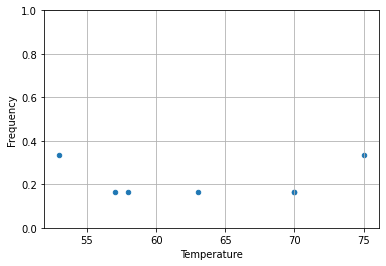

In [3]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

At first glance, the dependence does not look very important, but let's try to
estimate the impact of temperature $t$ on the probability of O-ring malfunction.

## Estimation of the temperature influence

Suppose that each of the six O-rings is damaged with the same
probability and independently of the others and that this probability
depends only on the temperature. If $p(t)$ is this probability, the
number $D$ of malfunctioning O-rings during a flight at
temperature $t$ follows a binomial law with parameters $n=6$ and
$p=p(t)$. To link $p(t)$ to $t$, we will therefore perform a
logistic regression.

In [4]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(link=sm.families.links.logit())).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                    7
Model:                            GLM   Df Residuals:                        5
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2.5250
Date:                Fri, 22 Oct 2021   Deviance:                      0.22231
Time:                        13:13:23   Pearson chi2:                    0.236
No. Iterations:                     4   Pseudo R-squ. (CS):          1.926e-05
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3895      7.828     -0.178      0.859     -16.732      13.953
Temperature     0.0014      0.122      0.012      0.991      -0.238       0.240
===============================================================================
"""

The most likely estimator of the temperature parameter is 0.0014
and the standard error of this estimator is 0.122, in other words we
cannot distinguish any particular impact and we must take our
estimates with caution.

## Estimation of the probability of O-ring malfunction

The expected temperature on the take-off day is 31°F. Let's try to
estimate the probability of O-ring malfunction at
this temperature from the model we just built:

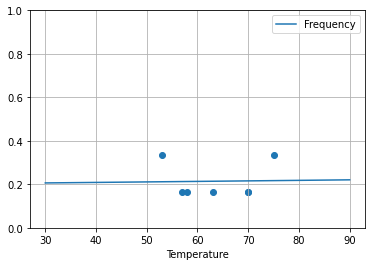

In [5]:
%matplotlib inline
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

As expected from the initial data, the
temperature has no significant impact on the probability of failure of the
O-rings. It will be about 0.2, as in the tests
where we had a failure of at least one joint. Let's get back
to the initial dataset to estimate the probability of failure:

In [6]:
data = pd.read_csv("data/shuttle.csv")
print(np.sum(data.Malfunction)/np.sum(data.Count))

0.06521739130434782


This probability is thus about $p=0.065$. Knowing that there is
a primary and a secondary O-ring on each of the three parts of the
launcher, the probability of failure of both joints of a launcher
is $p^2 \approx 0.00425$. The probability of failure of any one of the
launchers is $1-(1-p^2)^3 \approx 1.2%$.  That would really be
bad luck.... Everything is under control, so the takeoff can happen
tomorrow as planned.

But the next day, the Challenger shuttle exploded and took away
with her the seven crew members. The public was shocked and in
the subsequent investigation, the reliability of the
O-rings was questioned. Beyond the internal communication problems
of NASA, which have a lot to do with this fiasco, the previous analysis
includes (at least) a small problem.... Can you find it?
You are free to modify this analysis and to look at this dataset
from all angles in order to to explain what's wrong.

## Comments

All the statistics look reasonable at a first glance. However, the sample is quite small (22 observations) and the considered temperatures are quite far from the launch temperature (30 °F), which can lead to non accurate predictions. In addition, excluding the observations without failures makes it difficult for the model to learn how the temperature impacts on having a failure or not, and not only on the number of failures. Pressure can also be an important predictor that is not taken into account for the analysis.

The same analysis can therefore be repeated, considering all observations and pressure as an additional predictor.

## The new analysis

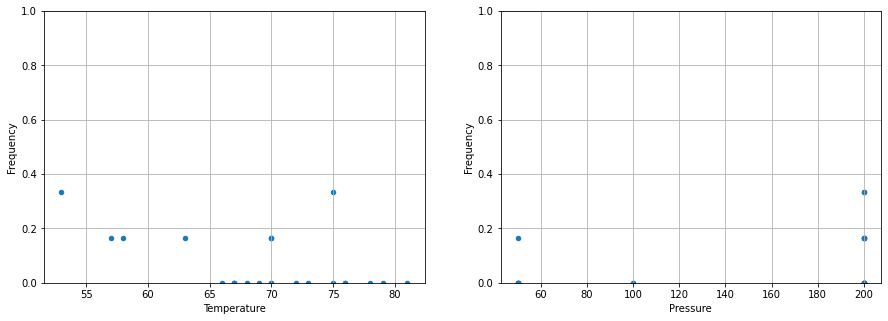

In [7]:
# Reload data
data = pd.read_csv("data/shuttle.csv")
#Graphical inspection
data["Frequency"]=data.Malfunction/data.Count
_, axs = plt.subplots(1, 2, figsize=(15, 5))
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1],ax=axs[0])
data.plot(x="Pressure",y="Frequency",kind="scatter",ylim=[0,1],ax=axs[1])
axs[0].grid(True)
axs[1].grid(True)

Only by graphical inspection, it is clear that temperature has indeed a big impact on failures: they are unlikely over 65 °F. On the other hand, no contribution of pressure can be observed.

In [8]:
# Estimation of temperature and pressure influence
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature','Pressure']], family=sm.families.Binomial(sm.families.links.logit())).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       20
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.7926
Date:                Fri, 22 Oct 2021   Deviance:                       2.7576
Time:                        13:13:24   Pearson chi2:                     4.19
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05416
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5202      8.541      0.295      0.768     -14.220      19.260
Temperature    -0.0983      0.110     -0.894      0.371      -0.314       0.117
Pressure        0.0085      0.019      0.451      0.652      -0.028       0.045
===============================================================================
"""

Unlike the previous fit of logistic regression, the most likely estimator of the temperature parameter is not negligible and has negative value, implying a slightly negative correlation between temperature and probability of failure (the lower the temperature, the higher the probability). The p-value corresponding to the null hypothesis that its parameter can be set to 0 without loss of information is also lower (0.371). The estimated parameter for the pressure is instead very close to 0. A new model is therefore fit without taking pressure into account.

In [9]:
# Estimation of temperature influence
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit())).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.9210
Date:                Fri, 22 Oct 2021   Deviance:                       3.0144
Time:                        13:13:24   Pearson chi2:                     5.00
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04355
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.0850      7.477      0.680      0.496      -9.570      19.740
Temperature    -0.1156      0.115     -1.004      0.316      -0.341       0.110
===============================================================================
"""

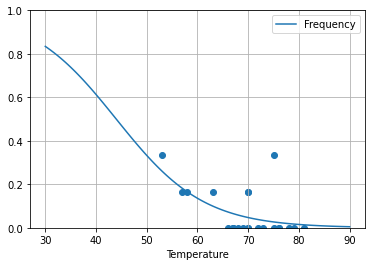

In [10]:
# Estimation of the probability of O-ring malfunction
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

The final prediction of O-ring failure depending on the temperature is completely different than before! Considering all the flights for the analysis, successful and failed, the estimated probability of failure around 30 °F is slightly higher than 80%. This result would have suggested that the Challenger flight was very unadvisable in the morning of January 28, 1986.